# Homework 3  - Part B


###### Roll Number:21100328

We'll start Part B by taking out a minute to thank creators of Tensorflow and Keras for making our lives easier. The goal of this home work is to design a convolutional neural network to classify images from CIFAR-10. CIFAR-10 is a subset of CIFAR-100 with 10 and 100 being number of classes. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. We'll be building small CNNs using Keras to solve this classification task.
<br>

Please note:
- You have to save each trained model weights and tensorboard logs in different folder. Use proper names for the model
- You have to show trainings in this notebook file, so make sure that the printings and figures are available on this notebook file
- This notebook is also your report file. So add your comments and analysis of each task. Your comments and analysis are as important as your code. This would be considered short report and it is compulsory part of the homework.
- Your system memory may overflow. In that case, please reset memory for trained model(s) keeping printed logs and history of trained model. History of all trained models could be used to plot the trends.
- For trends you shall also use tensorboard logs 

### Imports

In [0]:
import keras
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam , SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K

from sklearn.model_selection import train_test_split
from IPython.display import display

import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# !pip install tensorflow==1.14
import tensorflow as tf
import os
import glob
your_id = 21100328
np.random.seed(your_id)
# os.listdir('drive/My Drive/fastai-v3/cifar/train')

In [0]:
# !pip install tensorflow-gpu==1.14

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/fastai-v3/cifar.zip','r') as zipobj:
  zipobj.extractall();

###### Hyperparameters

In [0]:
batch_size = 64
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
input_shape_cifar = (32,32,3)
images_dir = '/content/cifar/'
epochs = 8
all_histories = []

['test', 'train', 'labels.txt']

### Task 1.1   Load dataset information
Download the [CIFAR-10 Dataset](https://drive.google.com/drive/folders/1FPsts3C2tJMVQ1xcCi2XZdb2z_J2OjSr?usp=sharing) and setup your working directory. Be sure to put the dataset in the <code>images_dir</code> directory. We won't be loading images and will only store the file paths in memory. These file paths will be used to load and return batch of images in our generator. Feel free to explore the dataset in this section.

In [0]:
print(images_dir)
train_dir = images_dir + 'train/'
test_dir = images_dir + 'test/'
label_dir = images_dir + 'labels.txt'

# Use either os.listdir or glob to generate an array of file
# paths for training and testing data (I would recommend using glob)
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# Use labels.txt to store labels in an array/dict# (NOTE: The line number corresponds to the actual label)
classes = [line.strip() for line in open(label_dir)]

# Use sci-kit learn's train_test_split method to generate a validation dataset from the training dataset
train_files , val_files = train_test_split(train_files ,test_size=0.2, random_state=42)
# to_categorical(test_files, num_classes)
# len(test_files)

/content/cifar/


### Task 1.2 Preprocessing
Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. 

###### Task 1.2.1 
In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.

In [0]:
def preprocessing_norm(images):
    return images/255

###### Task 1.2.2
Compute the channel-wise mean and standard deviation (std). Subtract channel-wise mean and divide by channel-wise std. This will shift the mean to zero and variation to 1 for each channel. 

In [0]:
def preprocessing_meanShift(images):
    mean = np.mean(images ,axis=(0,1))
    std = np.std(images ,axis=(0,1))
    return (images-mean)/std

In [0]:
dict_={}
for i in range(10):
    dict_ [classes[i]]=class_labels[i]
print(dict_)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


### Task 1.3  Batch Generator
Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. A data generator yields a tuple of (Xs,Ys) whenever the generator is used via the next() function. Implementation of a data generator is open ended, you can add whatever arguments you find necessary in addition to the ones provided.

In [0]:
import re
regex= lambda a :re.sub(r'[0-9]|_|.png','',a)

def get_sample(sample,preprocessing ,dir_):
    im = cv2.imread(os.path.join(dir_,sample))
    if preprocessing=='norm' :
      im=preprocessing_norm(im)
    elif preprocessing=='mean_shift':
      im=preprocessing_meanShift(im)
    label=regex(sample)
    label= dict_[label]
    return im, label


In [0]:
def data_generator(list_d,dir_, batch_size = 32, preprocessing = None):
    
    loop = int(len(list_d)/batch_size)
#     print(loop)
    count = 0
    count2=batch_size

    while True:
        count = 0
        count2=batch_size

        for i in range(loop):
            pics= list_d[count:count2]
            XS = [get_sample(x,preprocessing ,dir_) for x in pics]
            YS = np.array([label for img, label in XS])
            XS = [np.stack(img) for img, label in XS]        
            xs = np.asarray(XS)
            ys = np.reshape(YS,(len(YS),1))
            ys = to_categorical(ys,num_classes)
            count+=batch_size
            count2+=batch_size
            yield (xs,ys)

**IMPORTANT**: For each model you create, you need to conduct analysis in a markdown cell below the code cell containing the model's training. Your analysis should include plots, comments on its accuracy/loss, etc. Try to predict images and see what images your model is correctly classifying, see if your model is overfitting or not. For each layer you add, specify its function and then comment on its results.

In [0]:
input_img = Input(shape=(input_shape_cifar), name='input_img')
l = Conv2D(64, kernel_size=(2,2), activation='relu')(input_img) #learning 64 filters of size 2 by 2 
l = Conv2D(32, (3, 3),activation='relu')(l) # 32 filter of 3 by 3 shape
l = Flatten()(l) # making a single vector of layer
layer4 = Dense(128, activation='relu')(l) #fully connected dense layer
layer4 = Dense(64, activation='relu')(l) # fully connected dense layer
output = Dense(num_classes, activation='softmax')(layer4) # out put layer of size 10(classes)
model_initial = Model(inputs= input_img , outputs=output )
model_initial.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 31, 64)        832       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 29, 29, 32)        18464     
_________________________________________________________________
flatten_6 (Flatten)          (None, 26912)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                1722432   
_________________________________________________________________
dense_17 (Dense)             (None, 10)                650       
Total params: 1,742,378
Trainable params: 1,742,378
Non-trainable params: 0
_________________________________________________

#### Compile model and plot

In [0]:
model_name = 'base_model'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
 # You may tweak the learning rate
adam = Adam(lr=0.001)
# Use the appropriate loss function and compile the model
model_initial.compile(loss='categorical_crossentropy',  optimizer=adam,  metrics=['accuracy'])

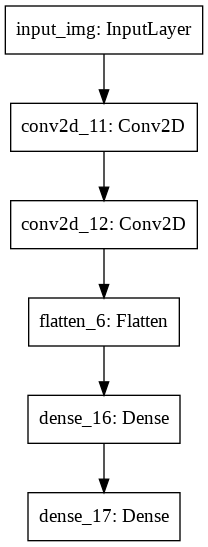

In [0]:
plot_model(model_initial, model_name+'/'+model_name+'.png')

#### Task 1.5 Training model
In order to train the model, instead of "model.fit" function, we will use the "model.fit_generator" function for training. For details check out [keras documentation](https://keras.io/models/sequential/)

In [0]:
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

In [0]:
# Add the following callbacks to your Model: ModelCheckpoin, CSVLogger, ReduceLROnPlateau. 
# callback for Tensorboard has already been provided to you.

checkpoint = ModelCheckpoint(model_name+'/' + model_name+'.h5' ,verbose =1 , save_best_only= True  
                             , monitor='val_loss' , mode= 'auto')



csvlogger = CSVLogger(model_name+'/logs.h5', separator = ',', append=True)

reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)

tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks =[checkpoint , csvlogger ,reducelr ,tensorboard ,TensorBoardColabCallback(tbc)]

#### Task 1.5.1 
Train model without using any pre-processing scheme

In [0]:
# Create three generators: For training your model, |for validation, for testing.
train_gen = data_generator(train_files,train_dir ,batch_size , preprocessing='None')
Valid_gen = data_generator(val_files,train_dir , batch_size  , preprocessing='None')
test_gen = data_generator(test_files ,batch_size   , preprocessing='None')

In [0]:
# Start training your model here
hist_initial = []
hist_initial = model_initial.fit_generator(train_gen,
                            epochs=epochs,
                            validation_data=Valid_gen,
                            validation_steps=1,
                            steps_per_epoch=len(train_files)//batch_size,
                            callbacks=callbacks,
                            verbose=1)
all_histories.append(hist_initial)

Epoch 1/8
625/625 [==============================] - 8s 13ms/step - loss: 14.5172 - acc: 0.0993 - val_loss: 14.6070 - val_acc: 0.0938

Epoch 00001: val_loss improved from inf to 14.60702, saving model to model_batch_normalized/model_batch_normalized.h5
Epoch 2/8
625/625 [==============================] - 8s 13ms/step - loss: 14.5172 - acc: 0.0993 - val_loss: 14.6070 - val_acc: 0.0938

Epoch 00002: val_loss improved from 14.60702 to 14.60702, saving model to model_batch_normalized/model_batch_normalized.h5
Epoch 3/8
625/625 [==============================] - 8s 13ms/step - loss: 14.5172 - acc: 0.0993 - val_loss: 13.8515 - val_acc: 0.1406

Epoch 00003: val_loss improved from 14.60702 to 13.85149, saving model to model_batch_normalized/model_batch_normalized.h5
Epoch 4/8
625/625 [==============================] - 8s 13ms/step - loss: 14.5172 - acc: 0.0993 - val_loss: 15.1107 - val_acc: 0.0625

Epoch 00004: val_loss did not improve from 13.85149
Epoch 5/8
625/625 [=========================

#### Task 1.5.2 
Train model by using data preprocessing i.e normalization or mean shift. 

In [0]:
input_img = Input(shape=(input_shape_cifar), name='input_img')

l = Conv2D(64, kernel_size=(2,2), activation='tanh')(input_img)
l = Conv2D(32, (4, 4) ,activation='tanh')(l)
l = Flatten()(l)

layer4 = Dense(120, activation='relu')(l)
layer5 = Dense(60, activation='relu')(l)

output = Dense(num_classes, activation='softmax')(layer5)
model_preprocessed = Model(inputs= input_img , outputs=output )
model_preprocessed.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 31, 31, 64)        832       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        32800     
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 60)                1505340   
_________________________________________________________________
dense_20 (Dense)             (None, 10)                610       
Total params: 1,539,582
Trainable params: 1,539,582
Non-trainable params: 0
_________________________________________________

In [0]:
model_name = 'model_preprocessed_input'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
# You may tweak this Learning Rate
adam = Adam(lr=0.0001)

# Compile your model using an appropriate loss
model_preprocessed.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

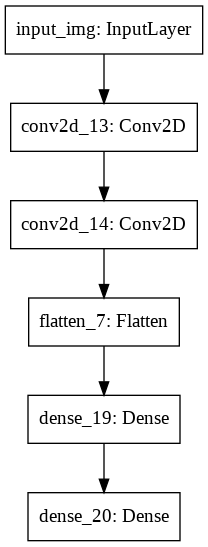

In [0]:
plot_model(model_preprocessed, model_name+'/'+model_name+'.png')

In [0]:
model_preprocessed.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 31, 31, 64)        832       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        32800     
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 60)                1505340   
_________________________________________________________________
dense_20 (Dense)             (None, 10)                610       
Total params: 1,539,582
Trainable params: 1,539,582
Non-trainable params: 0
_________________________________________________

In [0]:
# Add the following callbacks: ModelCheckpoint, CSVLogger. The callback for tensorboard has been provided to you.
checkpoint = ModelCheckpoint(model_name+'/' + model_name+'.h5' ,verbose =1 , 
                             save_best_only= True  , monitor='val_loss' , mode= 'auto')

csvlogger = CSVLogger(model_name+'/logs.h5', separator = ',', append=True)

tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [csvlogger,checkpoint,tensorboard]

In [0]:
# Create three generators again
norm_train_gen = data_generator(train_files, train_dir,batch_size , preprocessing='norm')
norm_Valid_gen = data_generator(val_files ,train_dir, batch_size  , preprocessing='norm')
norm_test_gen = data_generator(test_files ,batch_size   , preprocessing='mean_shift')

In [0]:
hist_preprocessed =[] 
hist_preprocessed = model_preprocessed.fit_generator(norm_train_gen,
                            epochs=epochs,
                            validation_data=norm_Valid_gen,
                            validation_steps=1,
                            steps_per_epoch=len(train_files)//batch_size,
                            callbacks=callbacks,
                            verbose=1)
all_histories.append(hist_preprocessed)


Epoch 1/8
625/625 [==============================] - 9s 15ms/step - loss: 1.2541 - acc: 0.5689 - val_loss: 1.6751 - val_acc: 0.4531

Epoch 00001: val_loss did not improve from 1.31166
Epoch 2/8
625/625 [==============================] - 9s 15ms/step - loss: 1.2166 - acc: 0.5841 - val_loss: 1.3816 - val_acc: 0.4688

Epoch 00002: val_loss did not improve from 1.31166
Epoch 3/8
625/625 [==============================] - 9s 15ms/step - loss: 1.1819 - acc: 0.5949 - val_loss: 1.7678 - val_acc: 0.3750

Epoch 00003: val_loss did not improve from 1.31166
Epoch 4/8
625/625 [==============================] - 9s 15ms/step - loss: 1.1478 - acc: 0.6070 - val_loss: 1.5343 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 1.31166
Epoch 5/8
625/625 [==============================] - 9s 15ms/step - loss: 1.1144 - acc: 0.6198 - val_loss: 1.2436 - val_acc: 0.5312

Epoch 00005: val_loss improved from 1.31166 to 1.24359, saving model to model_batch_normalized/model_batch_normalized.h5
Epoch 6/8


### Task 2.1 Pooling
Now, you need to modify the model by adding pooling layer(s). Pooling could be average pooling or max pooling. You can use the size and stride for pooling of your choice. 
<br> 
Modify the network by introducing pooling layer and train the model using the __fit_generator__ function. 

In [0]:
model_name = 'model_pooling'

input_img = Input(shape=(input_shape_cifar), name='input_img')

l = Conv2D(64, kernel_size=(2,2), activation='tanh')(input_img) 
l = MaxPooling2D()(l)
l = Conv2D(32, (4, 4) ,activation='tanh')(l)
l = Flatten()(l)
layer4 = Dense(120, activation='relu')(l)
layer5 = Dense(60, activation='relu')(l)

output = Dense(num_classes, activation='softmax')(layer5)
model_pooled = Model(inputs= input_img , outputs=output )
model_pooled.summary()

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 31, 31, 64)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 32)        32800     
_________________________________________________________________
flatten_8 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 60)                276540    
_________________________________________________________________
dense_23 (Dense)             (None, 10)                610 

In [0]:
adam = Adam(lr=0.001)
model_pooled.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
plot_model(model_pooled, model_name+'/'+model_name+'.png')
model_pooled.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 31, 31, 64)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 32)        32800     
_________________________________________________________________
flatten_8 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 60)                276540    
_________________________________________________________________
dense_23 (Dense)             (None, 10)                610 

In [0]:
# Add the following callbacks: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/' + model_name+'.h5' ,verbose =1 , 
                             save_best_only= True  , monitor='val_loss' , mode= 'auto')
csvlogger = CSVLogger(model_name+'/logs.h5', separator = ',', append=True)

tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint,csvlogger,tensorboard]

In [0]:
# Create three generators again
pool_train_gen = data_generator(train_files, train_dir,batch_size , preprocessing='norm')
pool_Valid_gen = data_generator(val_files ,train_dir, batch_size  , preprocessing='norm')
norm_test_gen = data_generator(test_files ,batch_size   , preprocessing='norm')

In [0]:
hist_pooled =[]
hist_pooled = model_pooled.fit_generator(pool_train_gen,
                            epochs=epochs,
                            validation_data=pool_Valid_gen,
                            validation_steps=1,
                            steps_per_epoch=len(train_files)//batch_size,
                            callbacks=callbacks,
                            verbose=1)
all_histories.append(hist_pooled)

Epoch 1/8
625/625 [==============================] - 9s 14ms/step - loss: 0.7432 - acc: 0.7424 - val_loss: 1.1645 - val_acc: 0.6719

Epoch 00001: val_loss improved from 1.24359 to 1.16450, saving model to model_batch_normalized/model_batch_normalized.h5
Epoch 2/8
625/625 [==============================] - 9s 14ms/step - loss: 0.7063 - acc: 0.7550 - val_loss: 1.0466 - val_acc: 0.6875

Epoch 00002: val_loss improved from 1.16450 to 1.04665, saving model to model_batch_normalized/model_batch_normalized.h5
Epoch 3/8
625/625 [==============================] - 9s 14ms/step - loss: 0.6649 - acc: 0.7688 - val_loss: 1.1271 - val_acc: 0.6875

Epoch 00003: val_loss did not improve from 1.04665
Epoch 4/8
625/625 [==============================] - 9s 14ms/step - loss: 0.6245 - acc: 0.7816 - val_loss: 1.6204 - val_acc: 0.5625

Epoch 00004: val_loss did not improve from 1.04665
Epoch 5/8
625/625 [==============================] - 9s 15ms/step - loss: 0.5888 - acc: 0.7942 - val_loss: 1.1579 - val_acc:

### Task 3.1 Dropout
Modify the network by introducing dropout layer(s) and train the model using the __fit_generator__ function. 

In [0]:
model_name = 'model_dropout'

input_img = Input(shape=(input_shape_cifar), name='input_img')
l = Conv2D(64, kernel_size=(2,2), activation='tanh')(input_img)
l = Dropout(0.2)(l)
l = Conv2D(32, (3, 3) ,activation='tanh')(l)
l = Flatten()(l)
layer4 = Dense(60, activation='relu')(l)
output = Dense(num_classes, activation='softmax')(layer4)

model_dropout = Model(inputs= input_img , outputs=output)
model_dropout.summary()

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 31, 31, 64)        832       
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 29, 29, 32)        18464     
_________________________________________________________________
flatten_9 (Flatten)          (None, 26912)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 60)                1614780   
_________________________________________________________________
dense_25 (Dense)             (None, 10)                610 

In [0]:
adam = Adam(lr=0.001)
model_dropout.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
plot_model(model_dropout, model_name+'/'+model_name+'.png')
model_dropout.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 31, 31, 64)        832       
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 29, 29, 32)        18464     
_________________________________________________________________
flatten_9 (Flatten)          (None, 26912)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 60)                1614780   
_________________________________________________________________
dense_25 (Dense)             (None, 10)                610 

In [0]:
checkpoint = ModelCheckpoint(model_name+'/' + model_name+'.h5' ,verbose =1 , 
                             save_best_only= True  , monitor='val_loss' , mode= 'auto')

csvlogger = CSVLogger(model_name+'/logs.h5', separator = ',', append=True)

tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint ,csvlogger,tensorboard]

In [0]:
# Create three Generators
drop_train_gen = data_generator(train_files, train_dir,batch_size , preprocessing=None)
drop_Valid_gen = data_generator(val_files ,train_dir, batch_size  , preprocessing=None)

In [0]:
hist_dropout=[]
hist_dropout = model_dropout.fit_generator(drop_train_gen,
                            epochs=epochs,
                            validation_data=drop_Valid_gen,
                            validation_steps=1,
                            steps_per_epoch=len(train_files)//batch_size,
                            callbacks=callbacks,
                            verbose=1)

all_histories.append(hist_dropout)

Epoch 1/8
625/625 [==============================] - 9s 14ms/step - loss: 2.3027 - acc: 0.0980 - val_loss: 2.3033 - val_acc: 0.0156

Epoch 00001: val_loss did not improve from 1.04665
Epoch 2/8
625/625 [==============================] - 9s 14ms/step - loss: 2.3027 - acc: 0.0973 - val_loss: 2.3038 - val_acc: 0.0625

Epoch 00002: val_loss did not improve from 1.04665
Epoch 3/8
625/625 [==============================] - 9s 14ms/step - loss: 2.3027 - acc: 0.0972 - val_loss: 2.3040 - val_acc: 0.1406

Epoch 00003: val_loss did not improve from 1.04665
Epoch 4/8
625/625 [==============================] - 9s 14ms/step - loss: 2.3027 - acc: 0.0973 - val_loss: 2.3031 - val_acc: 0.0625

Epoch 00004: val_loss did not improve from 1.04665
Epoch 5/8
625/625 [==============================] - 9s 14ms/step - loss: 2.3027 - acc: 0.0973 - val_loss: 2.3028 - val_acc: 0.1875

Epoch 00005: val_loss did not improve from 1.04665
Epoch 6/8
625/625 [==============================] - 8s 14ms/step - loss: 2.3027

### Task 4.1 Batch Normalization
Modify the network by introducing batch normalization layer(s) and train the model. 

In [0]:
model_name = 'model_batch_normalized'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
input_img = Input(shape=(input_shape_cifar), name='input_img')
l = Conv2D(64, kernel_size=(2,2), activation='tanh')(input_img)
l = BatchNormalization()(l)
l = Conv2D(32, (4, 4) ,activation='tanh')(l)

l = Flatten()(l)
layer4 = Dense(120, activation='relu')(l)
layer5 = Dense(60, activation='relu')(l)

output = Dense(num_classes, activation='softmax')(layer5)
model_normalized = Model(inputs= input_img , outputs=output)
# model_normalized = None

In [0]:
adam = Adam(lr=0.001)
model_normalized.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
plot_model(model_normalized, model_name+'/'+model_name+'.png')
model_normalized.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 31, 31, 64)        832       
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 32)        32800     
_________________________________________________________________
flatten_10 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 60)                1505340   
_________________________________________________________________
dense_28 (Dense)             (None, 10)                610

In [0]:
# Add the following checkpoints: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/' + model_name+'.h5' ,verbose =1 , 
                             save_best_only= True  , monitor='val_loss' , mode= 'auto')

cvslogger = CSVLogger(model_name+'/logs.h5', separator = ',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint,csvlogger ,tensorboard,TensorBoardColabCallback(tbc)]

In [0]:
# Create three generators
n_train_gen = data_generator(train_files, train_dir,batch_size , preprocessing='norm')
n_Valid_gen = data_generator(val_files ,train_dir, batch_size  , preprocessing='norm')
# norm_test_gen = data_generator(test_files ,batch_size   , preprocessing='mean_shift')

In [0]:
hist_normalized=[]
hist_normalized =model_normalized.fit_generator(n_train_gen,
                            epochs=epochs,
                            validation_data=n_Valid_gen,
                            validation_steps=1,
                            steps_per_epoch=len(train_files)//batch_size,
                            callbacks=callbacks,
                            verbose=1)
all_histories.append(hist_normalized)

Epoch 1/8
625/625 [==============================] - 10s 15ms/step - loss: 0.3204 - acc: 0.8795 - val_loss: 2.8878 - val_acc: 0.4844

Epoch 00001: val_loss improved from inf to 2.88784, saving model to model_batch_normalized/model_batch_normalized.h5
Epoch 2/8
625/625 [==============================] - 10s 15ms/step - loss: 0.3198 - acc: 0.8811 - val_loss: 3.3508 - val_acc: 0.4688

Epoch 00002: val_loss did not improve from 2.88784
Epoch 3/8
625/625 [==============================] - 10s 15ms/step - loss: 0.3122 - acc: 0.8844 - val_loss: 2.6707 - val_acc: 0.5156

Epoch 00003: val_loss improved from 2.88784 to 2.67070, saving model to model_batch_normalized/model_batch_normalized.h5
Epoch 4/8
625/625 [==============================] - 9s 15ms/step - loss: 0.3042 - acc: 0.8869 - val_loss: 1.9800 - val_acc: 0.5625

Epoch 00004: val_loss improved from 2.67070 to 1.97997, saving model to model_batch_normalized/model_batch_normalized.h5
Epoch 5/8
625/625 [==============================] - 10

### Task 5.1 Comparison of all models
In this task you need to plot the loss and accuracy for all models and __discuss__ which model has better performance and why do you think so.

In [0]:
# Plot accuracy of all models
def plotHistory(histories, names, metric):
    plt.clf() 
    x_axis = list(range(epochs))
    # print(x_axis)
    for hist, name in zip(histories, names):
        plt.plot(x_axis, hist.history[metric], label=metric+'_'+name)
        plt.scatter(x_axis, hist.history[metric])
    plt.legend()
    plt.title(metric)
    plt.show()

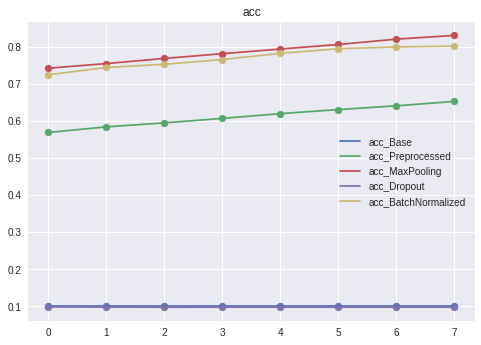

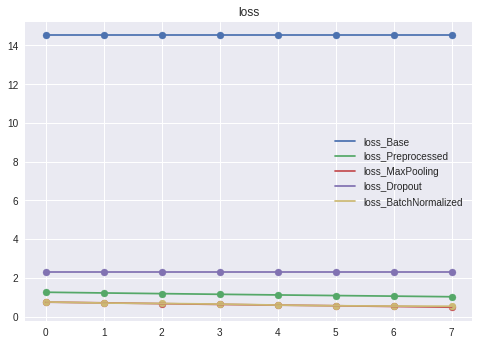

In [0]:
# Plot histories of all models
labels = ['Base', 'Preprocessed', 'MaxPooling', 'Dropout', 'BatchNormalized']
plotHistory(all_histories, labels, 'acc')
plotHistory(all_histories, labels, 'loss')

In [0]:
# !tensorboard --logdir '/content/base_model/'
# !tensorboard --logdir '/content/base_model/events.out.tfevents.1585442227.8c42a7d4210c'
# !pip install tensorboard
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://29555c7d.ngrok.io


#### Tensorboard 
We will be covering Tensorboard in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020)

You can run TensorBoard using the following command
```tensorboard --logdir=path/to/log-directory
```
Now for logs of all above trained models, take snapshot of the _loss_ and _accuracy_ plots and save in the directory where this notebook is. To show that saved plot here in notebook use following command in _markdown_ cell. 
<br> __![](path_to_image)__

**Add cells to include loss plots**

##### Add your analysis here

### Task 5.2 Visualize Activations
We will be covering this in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020). In this task, you are required to visualize the activations (outputs) of both the convolution layers of a model.

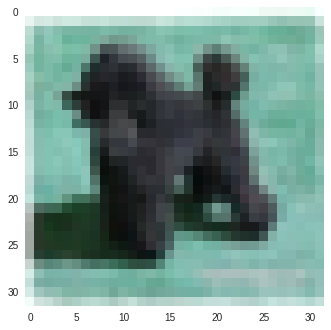

In [0]:
# Load any image here
test_image = [y for y in test_files if 'dog' in y]
test_image = cv2.imread(test_dir + test_image[10])
plt.gca().grid(False);

plt.imshow(test_image)

In [0]:
test_reshaped = test_image.reshape((1,32,32,3))
pred = model_normalized.predict(test_reshaped)
print('Label: ', classes[np.argmax(pred)])
# Get a prediction from ANY ONE of your models and output its label

Label:  horse


In [0]:
# Create a Model from the Input layer to a Convolutional Layer
layer_outputs = [layer.output for layer in model_normalized.layers]

pred_model = Model(inputs = model_normalized.input  , outputs=layer_outputs[1])

In [0]:
# Get a prediction for your chosen image using this model
predicted_activations = pred_model.predict(test_reshaped)

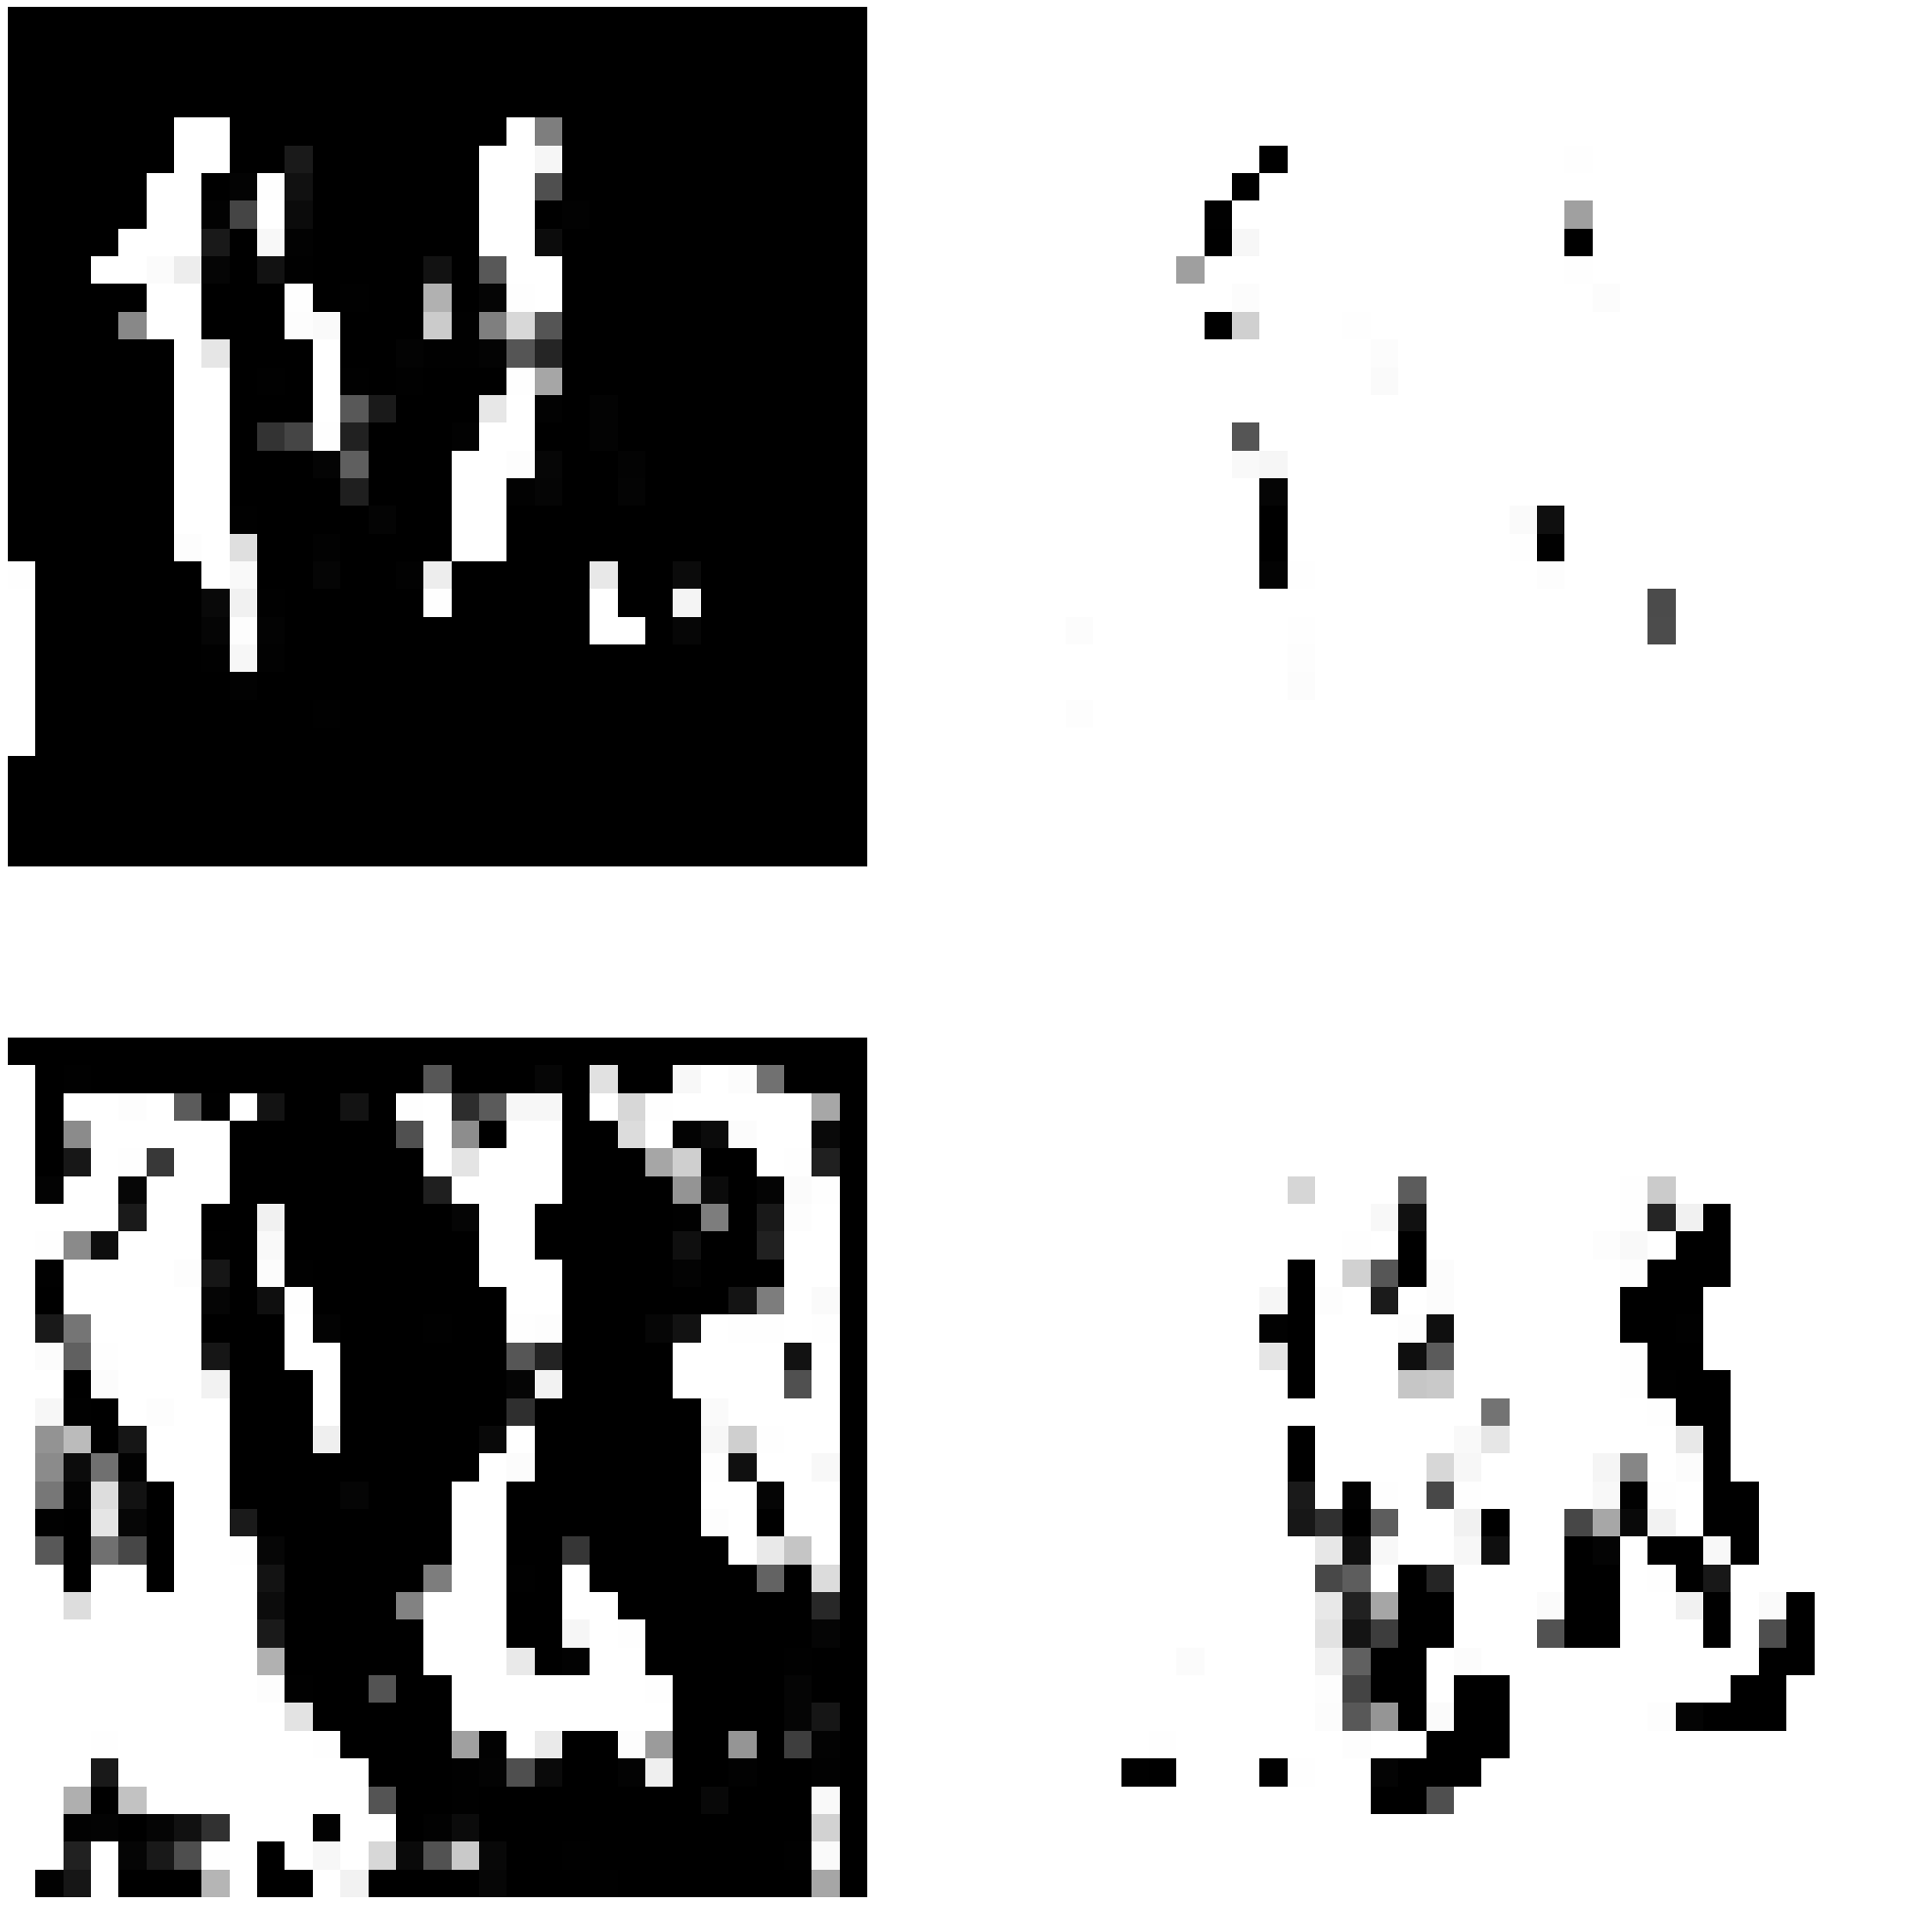

In [0]:
# Use your predictions to visualise the activations
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(32,32), dpi=80)

for i,ax in enumerate(axes.flatten()):
    ax.imshow(predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

In [0]:
# Create another model to visualize activations from ANOTHER convolutional layer

pred_model = Model (inputs =model_normalized.input  , outputs  = layer_outputs[2])

In [0]:
# You may rename this variable
second_predicted_activations = pred_model.predict(test_reshaped)

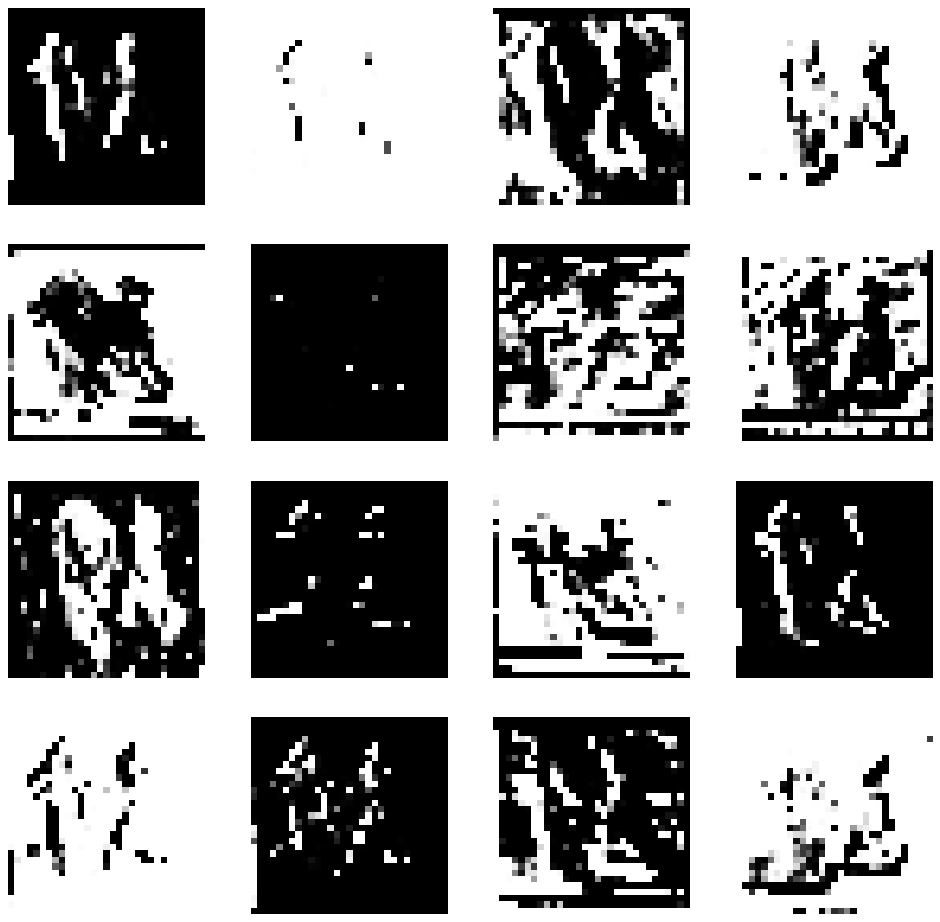

In [0]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15), dpi=80)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(second_predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

Q) What features from your chosen image do you think your model has been able to learn? In terms of filters (weights), what goes on when we add more convolutional layers in our models?




The dark patterns show how the mean activation is maximised through the layer. We see that the darker parts emphasize on features of the image. The model was able to find patterns to outline the boundary of the object in the image and also able to find focal points within the image.

Adding layers was able to emphasize on specific aspects of the image. Since information is lost with added layers, the features become sparse. There is a possibility of encountering the diminishing gradient problem as the information is lost through different filters.

Task 6.1 Effect of learning rate

### Task 6.1  Effect of learning rate
Take the best selected model in __Task 5.1__ and change its learning rate to: 
- 6.1.1 any value between 5 and 1.
- 6.1.2 learning rate = any value between 0.6 and  0.1 
- 6.1.3 learning rate = 0.00001

and train these three models to compare the effect learning rate.

In [0]:
# Use code provided in previous tasks
all_histories_lr = []

learning_rate = 4

model_name = 'model_lr_4'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

input_img = Input(shape=input_shape_cifar, name='input_img')
l = Conv2D(16, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(32, (3, 3),strides= 2, activation='tanh')(l)
l = Flatten()(l)
l = Dense(64, activation='relu')(l)
output_class = Dense(num_classes, activation='softmax')(l)

model_first = Model(inputs=input_img, outputs=output_class)

adam = Adam(lr=learning_rate)
model_first.compile(loss='mean_squared_error', 
              optimizer=adam, 
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, csvlogger, reducelr]

train_gen = data_generator(train_files, train_dir,batch_size , preprocessing='norm')
# test_gen = data_generator(test_files,32,'None')
val_gen = data_generator(val_files, train_dir,batch_size , preprocessing='norm')




hist_first = []
hist_first= model_first.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(train_files)//batch_size,
                           validation_data=val_gen,
                           validation_steps= int(len(val_files)//batch_size),
                           callbacks=callbacks, verbose=1)

all_histories_lr.append(hist_first)

Epoch 1/8
625/625 [==============================] - 10s 16ms/step - loss: 0.1801 - acc: 0.0990 - val_loss: 0.1792 - val_acc: 0.1042

Epoch 00001: val_loss improved from inf to 0.17917, saving model to model_lr_4/model_lr_4-01-0.18.h5
Epoch 2/8
625/625 [==============================] - 10s 15ms/step - loss: 0.1802 - acc: 0.0990 - val_loss: 0.1792 - val_acc: 0.1042

Epoch 00002: val_loss did not improve from 0.17917
Epoch 3/8
625/625 [==============================] - 10s 16ms/step - loss: 0.1802 - acc: 0.0990 - val_loss: 0.1792 - val_acc: 0.1042

Epoch 00003: val_loss did not improve from 0.17917
Epoch 4/8
625/625 [==============================] - 10s 16ms/step - loss: 0.1802 - acc: 0.0990 - val_loss: 0.1792 - val_acc: 0.1042

Epoch 00004: val_loss did not improve from 0.17917
Epoch 5/8
625/625 [==============================] - 10s 15ms/step - loss: 0.1802 - acc: 0.0990 - val_loss: 0.1792 - val_acc: 0.1042

Epoch 00005: val_loss did not improve from 0.17917
Epoch 6/8
625/625 [======

In [0]:
learning_rate = 0.3
model_name = 'model_lr_0.3'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
input_img = Input(shape=input_shape_cifar, name='input_img')
l = Conv2D(16, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(32, (3, 3),strides= 2, activation='tanh')(l)
l = Flatten()(l)
l = Dense(64, activation='relu')(l)
output_class = Dense(num_classes, activation='softmax')(l)

model_second = Model(inputs=input_img, outputs=output_class)

adam = Adam(lr=learning_rate)
model_second.compile(loss='mean_squared_error', 
              optimizer=adam, 
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, csvlogger, reducelr]

train_gen = data_generator(train_files, train_dir,batch_size , preprocessing='norm')
val_gen = data_generator(val_files, train_dir,batch_size , preprocessing='norm')




hist_second = []
hist_second= model_second.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(train_files)//batch_size,
                           validation_data=val_gen,
                           validation_steps= len(val_files)//batch_size,
                           callbacks=callbacks, verbose=1)

all_histories_lr.append(hist_second)

Epoch 1/8
625/625 [==============================] - 10s 16ms/step - loss: 0.1800 - acc: 0.0992 - val_loss: 0.1794 - val_acc: 0.1028

Epoch 00001: val_loss improved from inf to 0.17945, saving model to model_lr_0.3/model_lr_0.3-01-0.18.h5
Epoch 2/8
625/625 [==============================] - 10s 15ms/step - loss: 0.1801 - acc: 0.0993 - val_loss: 0.1794 - val_acc: 0.1028

Epoch 00002: val_loss did not improve from 0.17945
Epoch 3/8
625/625 [==============================] - 10s 16ms/step - loss: 0.1801 - acc: 0.0993 - val_loss: 0.1794 - val_acc: 0.1028

Epoch 00003: val_loss did not improve from 0.17945
Epoch 4/8
625/625 [==============================] - 10s 16ms/step - loss: 0.1801 - acc: 0.0993 - val_loss: 0.1794 - val_acc: 0.1028

Epoch 00004: val_loss did not improve from 0.17945
Epoch 5/8
625/625 [==============================] - 10s 15ms/step - loss: 0.1801 - acc: 0.0993 - val_loss: 0.1794 - val_acc: 0.1028

Epoch 00005: val_loss did not improve from 0.17945
Epoch 6/8
625/625 [==

In [0]:
learning_rate = 0.00001
model_name = 'model_lr_0.00001'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

input_img = Input(shape=input_shape_cifar, name='input_img')
l = Conv2D(16, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(32, (3, 3),strides= 2, activation='tanh')(l)
l = Flatten()(l)
l = Dense(64, activation='relu')(l)
output_class = Dense(num_classes, activation='softmax')(l)

model_third = Model(inputs=input_img, outputs=output_class)

adam = Adam(lr=learning_rate)
model_third.compile(loss='mean_squared_error', 
              optimizer=adam, 
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)

reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)

tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, csvlogger, reducelr]



train_gen = data_generator(train_files, train_dir,batch_size , preprocessing='norm')
val_gen = data_generator(train_files, train_dir,batch_size , preprocessing='norm')


hist_third = []
hist_third= model_third.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(train_files)//batch_size,
                           validation_data=val_gen,
                           validation_steps= len(val_files)//batch_size,
                           callbacks=callbacks, verbose=1)

all_histories_lr.append(hist_third)


Epoch 1/8
625/625 [==============================] - 10s 16ms/step - loss: 0.0872 - acc: 0.2126 - val_loss: 0.0847 - val_acc: 0.2767

Epoch 00001: val_loss improved from inf to 0.08474, saving model to model_lr_0.00001/model_lr_0.00001-01-0.08.h5
Epoch 2/8
625/625 [==============================] - 10s 15ms/step - loss: 0.0829 - acc: 0.3037 - val_loss: 0.0813 - val_acc: 0.3288

Epoch 00002: val_loss improved from 0.08474 to 0.08134, saving model to model_lr_0.00001/model_lr_0.00001-02-0.08.h5
Epoch 3/8
625/625 [==============================] - 10s 16ms/step - loss: 0.0805 - acc: 0.3328 - val_loss: 0.0792 - val_acc: 0.3569

Epoch 00003: val_loss improved from 0.08134 to 0.07920, saving model to model_lr_0.00001/model_lr_0.00001-03-0.08.h5
Epoch 4/8
625/625 [==============================] - 10s 16ms/step - loss: 0.0788 - acc: 0.3537 - val_loss: 0.0784 - val_acc: 0.3534

Epoch 00004: val_loss improved from 0.07920 to 0.07843, saving model to model_lr_0.00001/model_lr_0.00001-04-0.08.h5


### Task 6.2 Plot loss and accuracy
Plot the loss and accracy for best model selected in task 5.1, and model trained in 6.1.1, 6.1.2 and 6.1.3 task. Give the detailed analysis of the effect of learning rate in your words and select the best learning rate for this problem.

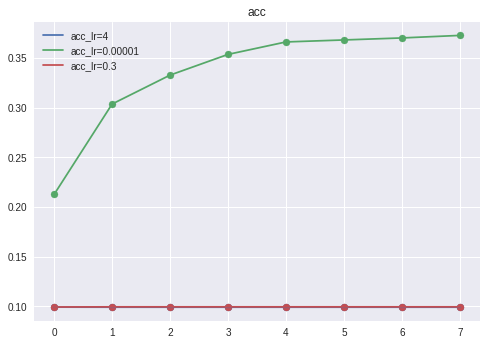

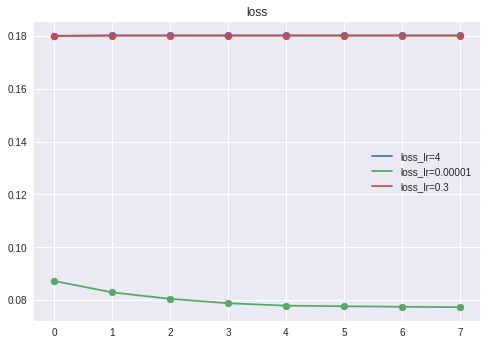

In [0]:
# Use plotHistory to make these plots
labels = ['lr=4', 'lr=0.00001','lr=0.3']
# print(len(all_histories))
plotHistory(all_histories_lr, labels, 'acc')
plotHistory(all_histories_lr, labels, 'loss')

Analysis: